# Part 2

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
from pylab import * 

In [3]:
def generate_data(m,n,winnow=False):
    """
    Given a combination of m and n, it generates a random data matrix X of dimensions (m x (n+1)).
    Each cell of this matrix will randomly be either -1 or 1.
    It also computes a corresponding X matrix of size (m x 1), which is the first column of X.
    :param m: the number of rows.
    :param n: the number of columns
    :param winnow: if this flag is set to true, cell values will be in the {0, 1} set instead of {-1, 1}
    :return: the generated x and y matrices
    """
    if winnow:
        data = np.random.randint(2, size=(m,(n+1)))
        data = np.sign(data)
    else:
        data = np.random.uniform(low=-1, high=1, size=(m,(n+1)))
        data = np.sign(data)
    x = data
    y = data[:,0]
    return x,y


def add_bias(x):
    """
    Transforms x by adding an extra column of "1", i.e. bias.
    :param x: a matrix of m examples and n columns
    :return: the transformed matrix x_with_bias, of m examples and n+1 columns
    """
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

## Binary Perceptron

In [4]:

def perceptron_train(x,y,max_epoch=20, tol=0.01, learning_rate=1,random_select=False,eta=0.00):
    
    """
    It trains a perceptron classifier over multiple epochs.
    :param x: a matrix of observations
    :param y: the corresponding labels
    :param max_epoch: the maximum epochs to perform over the data
    :param tol: a tolerance value, used as a convergence criterion for the error rate.
    :param learning_rate: the learning rate parameter of the perceptron
    :param random_select: whether or not to select a random number of times to train the perceptron
    :param eta: used as a threshold value to determine when to update weights
    :return: a set of weights W and the errors made in the last iteration
    """
    
    m_train = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    x = add_bias(x)
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m_train)
    W = np.zeros(n+1)
    R = np.sqrt(n+1) #max norm
    error_bound = (R/eta)**2 #maximum number of mistakes it makes before convergence. 
    num_errors = 0 
    
    if random_select:
        max_epoch =1
        m = np.random.randint(low=0, high=m_train) #select random number of times to train the perceptron. 
    else:
        m = m_train
        
    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0 
    
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            pred_t = W @ x_t 
            
            if pred_t* y_t < eta:
                num_errors +=1
                W = W + learning_rate*x_t.T*y_t
                errors[t] = num_errors 
                if num_errors>= error_bound:
                    break
                
        error_per_epoch[epoch] = num_errors
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
 
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                print('error rate< 10%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')
                    break
        
    return W, error_per_epoch[:epoch+1]


def perceptron_test(x_test,y_test,W):
    """
    Given a set of weights W, it calculates the perceptron predictions over an unlabelled set of data x_test 
    as well as the number of mistakes.
    :param x_test: an unlabelled set of data observations
    :param y_test: their corresponding labels
    :param W: the perceptron's wegight
    :return: the number of mistakes and the predictions over x_test
    """
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    pred = np.sign(x_test@W) 
    diff = pred - y_test
    mistakes = len(diff[diff!=0])   
    return mistakes,pred

## Winnow

In [6]:
def winnow_train(x,y,max_epoch=20,tol=0.01, learning_rate=1):
    """
    Trains a winnow classifier over a set of observations x and their corresponding labels y
    :param x: a matrix of observations 
    :param y: their corresponding labels
    :param max_epoch: the maximum number of epochs to perform over the data
    :param tol: a tolerance value, used as a convergence criterion for error rate
    :param learning_rate: the learning rate of the classifier
    :return: the vector of weights W, and the number of mistakes made in the last iteration
    """
    m = x.shape[0] 
    n = x.shape[1] 
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    W = np.ones(n+1)
    x = add_bias(x)
    gamma_bound = n/2
    mistake_bound = (n/gamma_bound)**2
    num_errors = 0 
    
    #for epoch in range(max_epoch):
    epoch = 0
    while epoch < max_epoch:   
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            gamma = W @ x_t
            
            if gamma>= gamma_bound:
                pred_t = 1
            else:
                pred_t = 0
            
            if pred_t != y_t:
                num_errors+=1
                power = (y_t - pred_t)*x_t/1.0 #1 when error made on positive class, -1 when error made on negative class
                W = W*(2**power) #element wise multiplication, and element wise power
                W[W>n] = n #Once weight>n, it should no longer change. 
                errors[t] = num_errors
                
        error_per_epoch[epoch] = num_errors
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                #print('error rate< 5%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')  
                    break
        epoch += 1
    return W, error_per_epoch[:epoch+1]

def winnow_test(x_test,y_test,W):
    """
    Given a set of unlabelled data x_test and a trained winnow classifier (its weights W), it predicts the labels
    for x_test and calculates the mistakes made.
    :param x_test: an unknown set of data
    :param y_test: their corresponding labels
    :param W: the weights matrix for the winnow algorithm
    :return: the number of mistakes made and the predictions for x_test
    """
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    n = x_test.shape[1]
    gamma = x_test@W
    pred = np.zeros(m_test)
    pred[gamma>=n/2] = 1
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

## Least Squares Regression

In [192]:
def compute_primal(X, Y):
    """
    Computes vector omega, which is called the primal form of the linear regression.
    :param X: the feature map vector
    :param Y: the target values of the data points
    :return: the vector omega
    """
    omega = np.linalg.pinv(X.T @ X) @ X.T @ Y
    return omega

def linear_predict(X_test, y_test, omega):
    """
    Given a set of unlabelled data x_test and a trained linear classifier (its weights omega), it predicts the labels
    for x_test and calculates the mistakes made.
    :param X_test: an unknown set of data
    :param y_test: their corresponding labels
    :param omega: the weights matrix for the linear regression
    :return: the number of mistakes made and the predictions for x_test
    """
    f = X_test @ omega
    pred = np.where(f < 0, -1, 1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    return mistakes, pred


## 1 Nearest Neighbors

In [8]:
def pairwise_distance_double(X1,X2): 
    """
    Computes the pairwise distance for two matrices X1 and X2
    :param X1: the first matrix
    :param X2: the second matrix
    :return: the pairwise distances matrix
    """
    
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def knn_test(x_test, y_test, x_train, y_train):
    """
    In the k-NN algorithm, given a set of unknown data x_test, we try to predict their corresponding labels by
    looking at the k nearest neighbours as seen in the training set x_train. This function is an implementation of 
    1nn in particular and it calculates the set of pairwise distances of x_test and x_train and then predicts the 
    labels of x_test using the label of the nearest neighbour.
    :param x_test: an unknown set of data
    :param y_test: their corresponding labels
    :param x_train: an array of observations, used as a training set
    :param y_train: their corresponding labels
    :return: the number of mistakes made and the predictions for x_test
    """
    distances = pairwise_distance_double(x_test, x_train)
    pred = np.zeros(x_test.shape[0])
    if x_test.shape[0] == 1:
        return 0, y_train
    
    pred = y_train[distances.argmin(axis=1)]
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    
    return mistakes,pred


## Estimate Sample Complexity

Justifying the choice of sample size: when n < log_2(1000), there is a possbility that the sample contains all possible combinations of n agents' outcomes. Igore this 

In [159]:
#Compute by brute force, the sample complexity of each training algorithms
#Might derive a lower bound for m for a fixed n. Refer to lecture notes. 

def calculate_gen_error(m, n, x_test, y_test, function_choice):
    """

    """
    if function_choice=='winnow':
        x,y = generate_data(m,n,winnow=True)
        W, _ = winnow_train(x,y,max_epoch=1,tol=0.01, learning_rate=1)
        test_mistakes,_ = winnow_test(x_test,y_test,W)
    elif function_choice == 'perceptron':
        x,y = generate_data(m,n)
        W, _ = perceptron_train(x,y,max_epoch=1, tol=0.01, learning_rate=1,random_select=True)
        test_mistakes,_= perceptron_test(x_test,y_test,W)
    elif function_choice == 'linear':
        x,y = generate_data(m,n)
        W = compute_primal(x,y)
        test_mistakes,_ = linear_predict(x_test, y_test, W)
        
    elif function_choice == '1nn':
        x,y = generate_data(m,n)
        test_mistakes,_ = knn_test(x_test, y_test, x, y)
        
    mean_test_error = (1.0/ y_test.shape[0]) * test_mistakes
    
    return mean_test_error



def estimate_generalization_error(m,n,number_of_samples,function_choice,test_size):
    """

    """
    test_errors=np.zeros(number_of_samples)
    
    for run in range(number_of_samples):
        if function_choice == 'winnow':
            x_test,y_test = generate_data(test_size,n,winnow=True)
        else:
            x_test,y_test = generate_data(test_size,n)
            
        test_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
        test_errors[run] = test_error          
    gen_error = test_errors.mean()   
    
    return gen_error



def estimate_sample_complexity(max_n,function_choice,step_size=1, number_of_runs=10, number_of_samples=10):
    """
    Binary Search to find the sample complexity
    :param max_n: an unknown set of data
    :param function_choice: their corresponding labels
    :param step_size: an array of observations, used as a training set
    :param number_of_runs: their corresponding labels
    :param number_of_samples: their corresponding labels
    :return: sample_complexity, 2D array that records the sample complexity computed for each n in each run
    :return: iterations_per_n, 1D array that records the number of m iterated for each n
    """
    sample_complexity = np.zeros((max_n, number_of_runs))
    iterations_per_n = np.zeros(max_n)
    gen_errors_matrix= np.zeros((max_n, number_of_runs))
    
    for n in np.arange(1,max_n+1,step_size):
        test_size = 10000
        print("Now n=", n, "............", end='\r')
        m_last = 0 
        #Repeat for number_of_runs runs. 
        for run in range(number_of_runs):
            if function_choice == 'winnow':
                x_test,y_test = generate_data(test_size,n,winnow=True)
            else:
                x_test,y_test = generate_data(test_size,n)
            
            m_left, m_right = bound_m(n,function_choice)
            
            error_left = estimate_generalization_error(m_left,n,number_of_samples,function_choice,test_size)
            error_right = estimate_generalization_error(m_right,n,number_of_samples,function_choice,test_size)
            
            min_m_per_run = 1
            min_error_per_run = 1
            m_current = n
            iterations = 1

            found_m = False
            while found_m==False:
                m = int((m_left + m_right) / 2)
                # Generalisation error is upper bound of training mistakes over total number of observations in D
                gen_error = estimate_generalization_error(m,n,number_of_samples,function_choice,test_size)
                # If we're at the case with only two elements, then converge
                if (m_right == m_left + 1):
                    min_m_per_run = m_left if error_left <= error_right else m_right
                    gen_error = error_left if error_left <= error_right else error_right
                    
                    if (gen_error<0.1):
                        found_m = True
                        break
                    else:
                        m = m_last
                        raise ValueError('gen error > 0.1 at converge point, m_left = m_right-1')
                        break
                        
                # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
                # Otherwise we will check (m, m_right)
                if gen_error < 0.1:
                    m_last = m #store the latest m where this bound is achieved, gives more stability.
                    if m < min_m_per_run:
                   
                        min_m_per_run = m
                        min_error_per_run = gen_error
                        
                    m_right = m            
                    error_right = estimate_generalization_error(m_right,n,number_of_samples,function_choice,test_size)
                        
                else:
                    m_left = m
                    error_left = estimate_generalization_error(m_left,n,number_of_samples,function_choice,test_size)
                
                m_current = m
                
                if m_left == m_right:
                    found_m = True
                    if (gen_error <0.1):
                        break
                    else:
                        m = m_last
                        raise ValueError('gen error > 0.1 at converge point')
                        break
                        
                iterations += 1
 
            gen_errors_matrix[n-1, run] = gen_error 
            sample_complexity[n-1, run] = min_m_per_run
            iterations_per_n[n-1] += iterations
        iterations_per_n[n-1] /= number_of_runs
        
    return sample_complexity, iterations_per_n

In [10]:
def bound_m(n,function_choice):
    if function_choice=='winnow':
        m_left=1
        m_right=n
        
    elif function_choice =='perceptron':
        m_left = n*2
        m_right = n*10+10
    
    elif function_choice =='linear':
        m_left = 1
        m_right = n+10
        
    elif function_choice =='1nn':
        m_left = 1
        m_right = int(3*n**3)+30
        
    return m_left, m_right

In [163]:
def plot_sample_complexity(sample_complexity,step_size,function_choice):
    means = np.mean(sample_complexity, axis=1)
    means_crop = means[means>0]
    errors = np.std(sample_complexity, axis=1)
    errors_crop = errors[means>0]
    plt.errorbar(np.arange(1,sample_complexity.shape[0]+1,step_size), means_crop, errors_crop, marker='^')
    plt.xlabel('n')
    plt.ylabel('sample complexity')
    plt.title('Estimated sample complexity for '+str(function_choice))

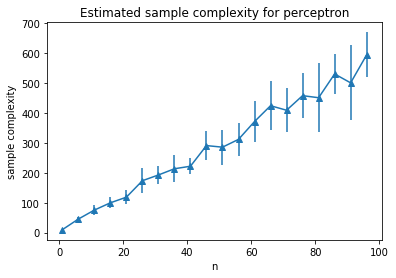

In [81]:
#Perceptron
sample_complexity_perceptron, iterations = estimate_sample_complexity(100,'perceptron',step_size=5,number_of_runs=10,number_of_samples=10)
plot_sample_complexity(sample_complexity_perceptron,step_size=5,function_choice='perceptron')

In [105]:
pd.DataFrame(sample_complexity_perceptron).to_pickle('sample_complexity_perceptron') 

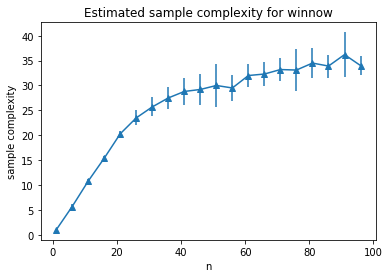

In [102]:
#Winnow
sample_complexity_winnow, iterations = estimate_sample_complexity(100,'winnow', step_size = 5, number_of_runs=10,number_of_samples=10) #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity_winnow,step_size=5,function_choice='winnow')

In [106]:
pd.DataFrame(sample_complexity_winnow).to_pickle('sample_complexity_winnow') 

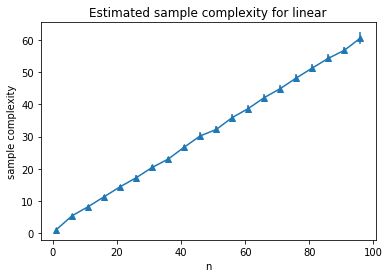

In [104]:
sample_complexity_linear, iterations = estimate_sample_complexity(100,'linear',step_size=5,number_of_runs=10,number_of_samples=10) #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity_linear,step_size=5,function_choice='linear')

In [107]:
pd.DataFrame(sample_complexity_linear).to_pickle('sample_complexity_linear') 

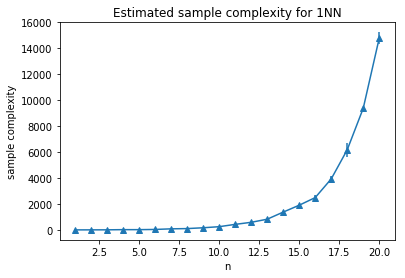

In [165]:
#1NN
sample_complexity_1nn, iterations = estimate_sample_complexity(20,'1nn',step_size=1,number_of_runs = 5,number_of_samples=5)
plot_sample_complexity(sample_complexity_1nn,step_size=1,function_choice='1NN')

In [166]:
pd.DataFrame(sample_complexity_1nn).to_pickle('sample_complexity_1nn') 

## Q1 c) Estimate m(n)

In [176]:
def fitting(sample_complexity, step_size,n_max,fitting_type='linear',function_type='Perceptron'):
    x_domain = np.arange(1,n_max,step_size)
    means = np.mean(sample_complexity, axis=1)
    means_crop = means[means>0]
    
    if fitting_type=='linear':
        m,b = polyfit(x_domain,means_crop,1)
        fit =  [b + m*x  for x in x_domain]
        print('estimated ϴ(m(n))=',round(b,2),'+ ',round(m,2),'n')
        
    
    elif fitting_type=='exponential':
        m,b = polyfit(x_domain,np.log(means_crop),1)
        fit =  [np.exp(b + m*x)  for x in x_domain]
        print('estimated ϴ(m(n))=',round(np.exp(b),2),'exp(',round(m,2),'n)')
       
      
    elif fitting_type=='log':
        m,b = polyfit(np.log(x_domain),means_crop,1)
        fit = [b + m*np.log(x)  for x in np.arange(1,100,step_size)]
        print('estimated ϴ(m(n))=',round(b,2),'+',round(m,2),'log(n)')
        
    plt.plot(x_domain,fit,color='r',label='fitted')
    plt.plot(x_domain,means_crop,color='b',label='actual')
    plt.title('Sample Complexity with ' + fitting_type +' fitting for '+ function_type)
    plt.ylabel('sample complexity')
    plt.xlabel('n')
    plt.show()

### Perceptron

estimated ϴ(m(n))= 5.79 +  5.84 n


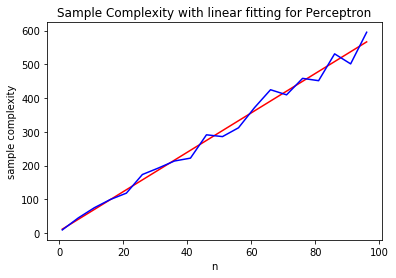

In [177]:
fitting(sample_complexity_perceptron, 5,100,fitting_type='linear')

### Winnow

estimated ϴ(m(n))= -5.15 + 8.78 log(n)


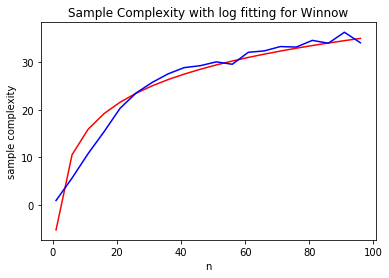

In [178]:
fitting(sample_complexity_winnow, 5,100,fitting_type='log',function_type='Winnow')

### Linear

estimated ϴ(m(n))= 1.25 +  0.62 n


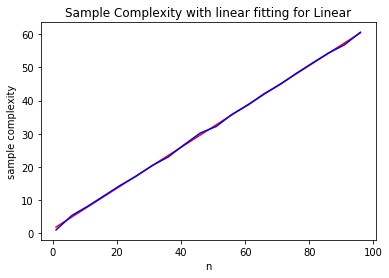

In [179]:
fitting(sample_complexity_linear, 5,100,fitting_type='linear',function_type='Linear')

### 1NN

estimated ϴ(m(n))= 3.95 exp( 0.41 n)


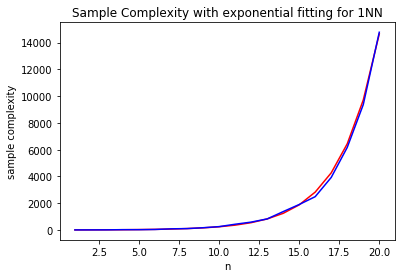

In [195]:
fitting(sample_complexity_1nn, 1,21,fitting_type='exponential',function_type='1NN')